In [34]:
import pandas as pd
import numpy as np
import scipy

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor 
from sklearn import metrics

import matplotlib.pyplot as plt
import seaborn as sns 
%matplotlib inline

# Data loading and pre-processing

In [2]:
main_df = pd.read_csv('main_task.csv')
y = main_df['Rating']
main_df = main_df.drop(['Rating'], axis=1)
main_df['purpose'] = 0
kaggle_df = pd.read_csv('kaggle_task.csv')
kaggle_df['purpose'] = 1
combined_df = pd.concat([main_df, kaggle_df])

## City

In [3]:
# Checking city
print("NAs #: ", combined_df.City.isna().sum())

city_dummies = pd.get_dummies(combined_df['City'])
combined_df = pd.concat([combined_df, city_dummies], axis=1)

NAs #:  0


## Additional feature - weighted rating

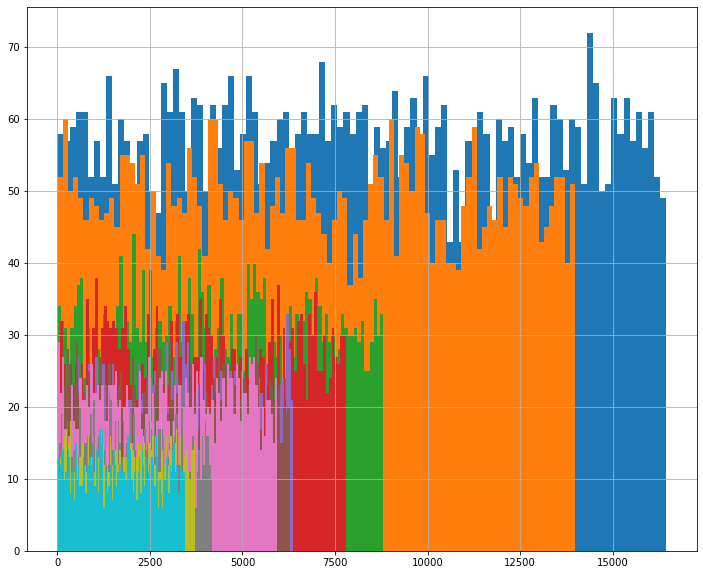

In [71]:
for x in (combined_df[combined_df.purpose==0]['City'].value_counts())[0:10].index:
    combined_df[combined_df.purpose==0]['Ranking'][combined_df[combined_df.purpose==0]['City'] == x].hist(bins=100)

It is easy to confirm that the number of restaraunts afffects the ranking feature which is per city. Since there is a correlation between the ranking and rating (which is demonstrated below), it makes sensee to make a featur to capture the relationship.

In [4]:
city_min_max = combined_df.groupby('City')['Ranking'].agg([min,max])
city_min_max = city_min_max.reset_index()

In [5]:
# weighted rating
def get_wr(row):
    city_min = city_min_max[city_min_max['City'] == row.City ]['min'].iloc[0]
    city_max = city_min_max[city_min_max['City'] == row.City ]['max'].iloc[0]
    wr = round((row['Ranking'] - city_min)/(city_max - city_min), 3)
    return wr

combined_df['wr'] = combined_df.apply(get_wr, axis=1)

## Cuisine Style

In [6]:
print("NAs #:  ", combined_df['Cuisine Style'].isna().sum())
combined_df['Cuisine Style'] = combined_df['Cuisine Style'].fillna("['Unknown']")

combined_df['Cuisines'] = combined_df['Cuisine Style'].str.findall(r"'(\b.*?\b)'")
combined_df['Cuisines_Num'] = combined_df['Cuisines'].apply(lambda x: len(x))
combined_df = pd.concat([combined_df, combined_df['Cuisines'].str.join('|').str.get_dummies()], axis=1)

NAs #:   11590


## Ranking

In [7]:
print("NAs #: ", combined_df['Ranking'].isna().sum())

NAs #:  0


In [68]:
pd.concat([combined_df[combined_df.purpose==0]['Ranking'], y], axis=1).corr()

,Ranking,Rating
Ranking,1.000000,-0.368371
Rating,-0.368371,1.000000


Ranking is one of a few quantitative features in the provided data. It demonstrates some correlation with the target feature.

## Price Range 

In [8]:
print("NAs #: ", combined_df['Price Range'].isna().sum())

etcombined_df['Price Range'].value_counts()

NAs #:  17361


$$ - $$$    23041
$            7816
$$$$         1782
Name: Price Range, dtype: int64

Let's also add squeares for this field as the pricing difference can be important.

In [9]:
combined_df['Price Range'] = combined_df['Price Range'].fillna('$$ - $$$')

price_range_encoding = {'$':1,'$$ - $$$':2,'$$$$':3}
combined_df['Price_Range'] = combined_df['Price Range'].map(lambda x: price_range_encoding[x])
combined_df['Price_Range_Squared']= combined_df['Price_Range'].map(lambda x: x*x)

## Number of reviews

In [10]:
print("NAs #: ", combined_df['Number of Reviews'].isna().sum())

NAs #:  3200


In [11]:
combined_df['Number of Reviews'].describe()

count    46800.000000
mean       124.471197
std        294.114345
min          2.000000
25%          9.000000
50%         33.000000
75%        115.000000
max       9660.000000
Name: Number of Reviews, dtype: float64

In [12]:
combined_df['Number of Reviews'] = combined_df['Number of Reviews'].fillna(combined_df['Number of Reviews'].median())

## ID_TA

This is a strange column. There appears to be no data in it, but the model can use it.

In [13]:
combined_df['ID_TA'] = combined_df['ID_TA'].apply(lambda x: int(x[1:]))

# Reviews

In [14]:
print("NAs #: ", combined_df['Reviews'].isna().sum())

combined_df['Reviews'] = combined_df['Reviews'].fillna("[[], []]")

NAs #:  2


In [15]:
# how many of empty reviews in total
len(combined_df[combined_df.Reviews == "[[], []]"])

8114

In [16]:
def cleanup_review_data(s):
    return s.strip("[]'' ")

def process_review(r):
    r = r.replace(", nan],", ", 'nan'],")
    r = r.replace("[nan,", "['nan',")
    
    reviews, dates = eval(r)
    assert len(reviews) == len(dates)
    
    while len(reviews) < 2:
        reviews.append(None), dates.append(None)
        
    return reviews[0], reviews[1], dates[0], dates[1]

combined_df['review1'], combined_df['review2'], combined_df['rdate1'], combined_df['rdate2'] = zip(*combined_df['Reviews'].map(process_review))

In [17]:
combined_df['rdate1'], combined_df['rdate2'] = pd.to_datetime(combined_df['rdate1']), pd.to_datetime(combined_df['rdate2'])

In [18]:
def date_to_part_of_year(r):
    if pd.isna(r):
        return 'Unknown'

    if r.month in [12, 1, 2]:
        return 'Winter'
    
    if r.month in [3,4,5]:
        return 'Spring'
    
    if r.month in[6,7,8]:
        return 'Summer'
    
    return 'Autumn'

combined_df['rdate1_part_of_year'] = combined_df['rdate1'].map(date_to_part_of_year)
combined_df['rdate2_part_of_year'] = combined_df['rdate2'].map(date_to_part_of_year)

In [19]:
combined_df = pd.concat([combined_df, pd.get_dummies(combined_df['rdate1_part_of_year'], prefix='rdate1')], axis=1)
combined_df = pd.concat([combined_df, pd.get_dummies(combined_df['rdate2_part_of_year'], prefix='rdate2')], axis=1)

## Would text features be useful?

In [52]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

train_review_df = combined_df[combined_df.purpose == 0][['review1', 'review2']]

train_review_df['review1'] = train_review_df.review1.fillna("")
train_review_df['review2'] = train_review_df.review2.fillna("")
train_review_df['combined_reviews'] = train_review_df['review1'] + train_review_df['review2']


cv = CountVectorizer(stop_words='english',max_features=1000)
cv_train_features = cv.fit_transform(train_review_df.combined_reviews)

tv = TfidfVectorizer(stop_words='english', sublinear_tf=True)
tv_train_features = tv.fit_transform(train_review_df.combined_reviews)

# Model

In [32]:
def round_rating(x):
    return np.round(x * 2) / 2

In [21]:
train_df = combined_df[combined_df.purpose == 0]

train_df = train_df.drop(['Restaurant_id', 'City', 'purpose', 'Cuisine Style', 'Cuisines', 'Price Range', 
                          'URL_TA', 'Reviews', 'review1', 'review2', 'rdate1', 'rdate2', 
                          'rdate1_part_of_year', 'rdate2_part_of_year'], axis=1)

## Regular + CountVectorizer features

In [35]:
train_features_with_cv = scipy.sparse.hstack([scipy.sparse.csr_matrix(train_df.values), cv_train_features])
X_train, X_test, y_train, y_test = train_test_split(train_features_with_cv, y, test_size=0.25)

regr = RandomForestRegressor(n_estimators=100, n_jobs=-1)

regr.fit(X_train, y_train)

y_pred = regr.predict(X_test)

y_pred = round_rating(y_pred)

print('MAE:', metrics.mean_absolute_error(y_test, y_pred))

MAE: 0.17555


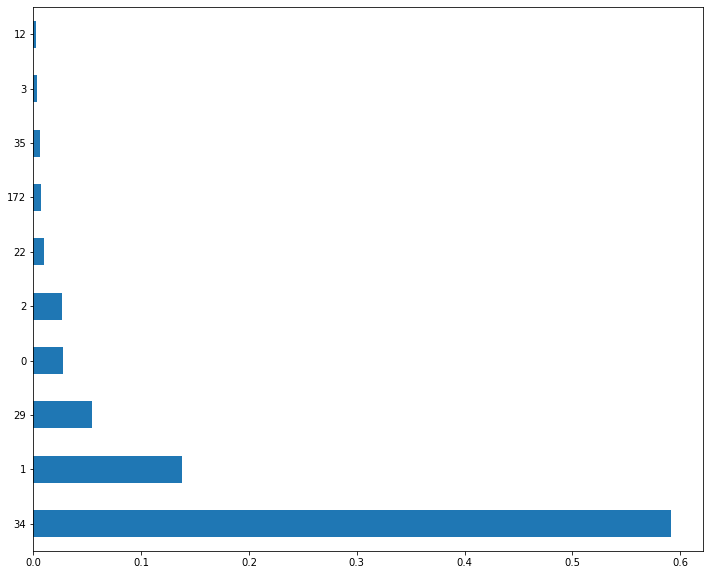

In [40]:
plt.rcParams['figure.figsize'] = (12,10)
feat_importances = pd.Series(regr.feature_importances_)
feat_importances.nlargest(10).plot(kind='barh')

No CV produced features (their indexes are > 174 seem to be very important

## Regular + TfidfVectorizer features

In [42]:
train_features_with_tfidf = scipy.sparse.hstack([scipy.sparse.csr_matrix(train_df.values), tv_train_features])
X_train, X_test, y_train, y_test = train_test_split(train_features_with_tfidf, y, test_size=0.25)

regr = RandomForestRegressor(n_estimators=100, n_jobs=-1)

regr.fit(X_train, y_train)

y_pred = regr.predict(X_test)

y_pred = round_rating(y_pred)

print('MAE:', metrics.mean_absolute_error(y_test, y_pred))

MAE: 0.17225


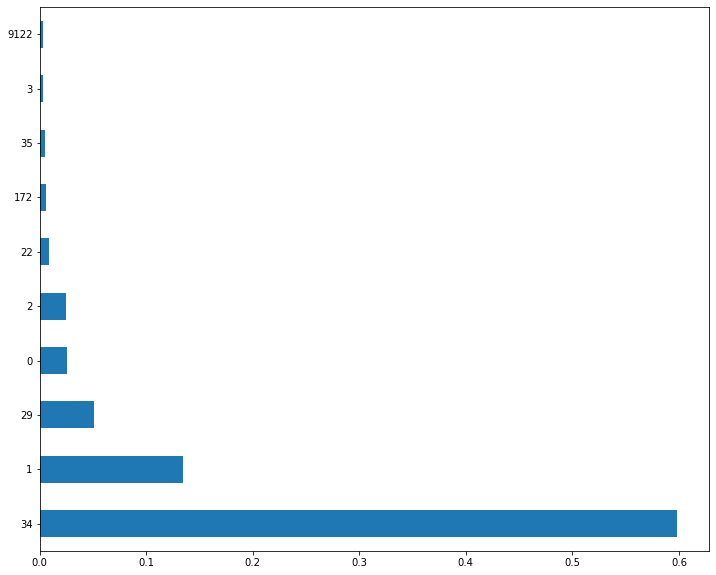

In [43]:
plt.rcParams['figure.figsize'] = (12,10)
feat_importances = pd.Series(regr.feature_importances_)
feat_importances.nlargest(10).plot(kind='barh')

There appears to be some improvement, although I can't say it is worth additional 25358 features produced by TF-IDF. However, potentially, a more complex model could be used (or at least the number of estimators increased)

# Submission

In [53]:
submit_df = combined_df[combined_df.purpose == 1]

submit_review_df = submit_df[['review1', 'review2']].fillna("")

submit_review_df['combined_reviews'] = submit_review_df['review1'] + submit_review_df['review2']

tv_submit_features = tv.transform(submit_review_df.combined_reviews)

submit_df = submit_df.drop(['Restaurant_id', 'City', 'purpose', 'Cuisine Style', 'Cuisines', 'Price Range', 
                          'URL_TA', 'Reviews', 'review1', 'review2', 'rdate1', 'rdate2', 
                          'rdate1_part_of_year', 'rdate2_part_of_year'], axis=1)

In [57]:
y_pred = regr.predict(scipy.sparse.hstack([scipy.sparse.csr_matrix(submit_df.values), tv_submit_features]))
y_pred = round_rating(y_pred)

In [58]:
### Leaderboard MAE: 0.17785
sample_submission = pd.read_csv('sample_submission.csv')
sample_submission['Rating'] = y_pred
sample_submission.to_csv('my_submission.csv', index=False)